# Cumulative Area Posterior Probability - CAPP

> MIT License  
> Copyright (c) 2019 Elias Martins Guerra Prado  
> https://github.com/Eliasmgprado/MineralProspectivityMapping  


## Import Libraries

In [95]:
import os
import geopandas as gpd
from osgeo import gdal
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, set_matplotlib_formats

import numpy as np
from matplotlib.ticker import FuncFormatter

import gc

plt.style.available
plt.style.use('fivethirtyeight')

set_matplotlib_formats('pdf', 'png')
#gpd.options.display.float_format = '{:.5f}'.format

rc={'axes.labelsize': 18,\
   'axes.titlesize': 22, 'font.size': 8, 'lines.linewidth': 1.5, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 15, 'ytick.labelsize': 15}

plt.rcParams.update(rc)
%matplotlib inline

## Variables (<span style="color:green">MODIFY THIS CELL</span>)
> Change this cell and run all cells bellow

In [84]:
#1 INPUT RASTER:
input_raster = 'D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\SVM_mode_2000_2000.tif' 

#2 RASTER CELL SIZE
CellSize = 125

#3 INPUT POINTS:
#3.1 TRAINING
input_points_t = 'D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\Wofe\sig\Cu_IOCG_Training.shp' 
#3.2 VALIDATION/TEST
input_points_v = 'D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\Wofe\sig\Cu_IOCG_Validation.shp' 

#4 RESULTS OUTPUT FOLDER (save CAPP .csv files and CAPP curve plot)
out_folder = 'D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\sig\\'

#DO NOT CHANGE 
UnitArea = 1

# Functions (<span style="color:red">DO NOT CHANGE THIS CELLS</span>)

In [96]:
def extractRasterVals(input_rasters, input_points):
    
    #points shp to df
    pnts_df = gpd.read_file(input_points)

    for i, rs in enumerate(input_rasters):

        presValues = []
        gdata = gdal.Open(rs)
        gt = gdata.GetGeoTransform()
        band = gdata.GetRasterBand(1)
        nodata = band.GetNoDataValue()

        x0, y0 , w , h = gt[0], gt[3], gt[1], gt[5]

        data = band.ReadAsArray().astype(np.float)
        #free memory
        del gdata



        if i == 0:
            #iterate through the points
            for p in pnts_df.iterrows():
                x = int((p[1]['geometry'].x - x0)/w)
                Xc = x0 + x*w + w/2 #the cell center x
                y = int((p[1]['geometry'].y - y0)/h)
                Yc = y0 + y*h + h/2 #the cell center y
                try:
                    if data[y,x] != nodata:
                        presVAL = [p[1]['geometry'].x,p[1]['geometry'].y, 
                                   '{:.6f}'.format(Xc), '{:.6f}'.format(Yc), data[y,x]]
                        presValues.append(presVAL)
                except:
                    pass
            df = pd.DataFrame(presValues, columns=['x', 'y', 'Xc', 'Yc', 'RASTERVALU'])
        else:
            #iterate through the points
            for p in pos.iterrows():
                x = int((p[1]['geometry'].x- x0)/w)
                y = int((p[1]['geometry'].y - y0)/h)
                try:
                    if data[y,x] != nodata:
                        presValues.append(data[y,x])
                except:
                    pass
            df[rs] = pd.Series(presValues)
        del data, band
    return df

In [97]:
def calcCapp(input_rasters,input_points):
    dbf_pd_arr = []
    print('>> Calc CAPP')
    print(f'input points: {input_points}')
    for i,input_raster in enumerate(input_rasters):
        print(i,input_raster)
        # Extract Point Raster Values
        
        points_rasterval_df = extractRasterVals([input_raster], input_points)
        
        Output_point_features = points_rasterval_df['RASTERVALU'].values
        num_training_sites = len(Output_point_features)
        
        unique_elements, counts_elements = np.unique(Output_point_features, return_counts=True)
        points_val_count = {}
        for k, v in zip(unique_elements,counts_elements):
            points_val_count[k] = v
            
        # Calc Pixel Area Factor
        output_dict = {}
        factor = (float(CellSize)**2) / 1000000 / UnitArea
        
        # Calc CAPP TAble
        gdata = gdal.Open(input_raster)
        band = gdata.GetRasterBand(1)


        arr = band.ReadAsArray().astype(np.float)
        unique_elements, counts_elements = np.unique(arr, return_counts=True)
        output_dict['RASTERVALU'] = unique_elements;
        output_dict['Count'] = counts_elements;
        output_dict['Area_sqkm'] = counts_elements*factor

        totalarea = sum(output_dict['Area_sqkm'])

        output_dict['CAPP_CumAr'] = np.cumsum(100.0*output_dict['Area_sqkm']/totalarea)
        output_dict['Eff_CumAre'] = np.flip(np.cumsum(100.0*np.flip(output_dict['Area_sqkm'])/totalarea))

        raster_val_count = {}
        for k, v in zip(unique_elements,counts_elements):
            raster_val_count[k] = v
            
        totalsites = sum(points_val_count.values())

        cumArea = 0
        effarea = []
        nSites = []

        sites = np.zeros(len(output_dict['RASTERVALU']))
        for v in list(points_val_count): 
            idx = (np.abs(output_dict['RASTERVALU'] - v)).argmin()
            sites[idx] = points_val_count[v]

        output_dict['Frequency'] = np.array(sites)
        
        output_dict['Cum_Sites'] = np.flip(np.cumsum(100*np.flip(output_dict['Frequency'])/totalsites))
        output_dict['I_CumSites'] = 100. - output_dict['Cum_Sites']
        
        Eff_CumAre_diff = (output_dict['Eff_CumAre'][:-1] - output_dict['Eff_CumAre'][1:])
        Eff_CumSites_diff = (output_dict['Cum_Sites'][:-1] + output_dict['Cum_Sites'][1:])
        eff_auc = 0.5 * Eff_CumAre_diff * Eff_CumSites_diff / (100.0 * 100.0)
        eff_auc = np.append(eff_auc,0.5 * output_dict['Eff_CumAre'][-1] * output_dict['Cum_Sites'][-1] / (100.0 * 100.0))
        output_dict['Eff_AUC'] = eff_auc
        
        out_CAPP_df = pd.DataFrame.from_dict(output_dict)
        
        dbf_pd_arr.append(out_CAPP_df)
        gc.collect()
    return dbf_pd_arr

In [90]:
def print_Area_Freq(dbf_pd_arr_t,dbf_pd_arr_v,xmin,name):
    
    #Plot Labels and Legend#####
    x_axis_label = 'Proportion of area predicted as prospective'
    y_axis_label = 'Proportion of training/test mineralized locations\ndelineated in predicted prospective zones'
    
    sucess_rate_legend = 'Sucess-rate'
    prediction_rate_legend='Prediction-rate'
    ################################
    
    # Calc 100% mineralized locations x value
    vl = []
    
    vl.append(dbf_pd_arr_t[0][dbf_pd_arr_t[0]['Cum_Sites'] > 99.99]['Eff_CumAre'].to_list()[-1])
    vl.append(dbf_pd_arr_v[0][dbf_pd_arr_v[0]['Cum_Sites'] > 99.99]['Eff_CumAre'].to_list()[-1])
    
    #Axis Ticks Formatter
    def perc(x, pos):
        return '%d%%' % (x)
    formatter = FuncFormatter(perc)
    
    #Make fig
    plt.figure(figsize=(13,9.3))
    ax = plt.axes()
    
    #Plot Sucess-Rate
    df = dbf_pd_arr_t[0]
    hull_idxs = [[0] + s.index[s].tolist() for k, s in df.ne(df.shift(-1)).filter(like='Cum_Sites').items()][0]
    plt.plot(df['Eff_CumAre'][hull_idxs], df['Cum_Sites'][hull_idxs], '-', lw=3, 
             label=sucess_rate_legend)

    #Plot Prediction-Rate
    df = dbf_pd_arr_v[0]
    hull_idxs = [[0] + s.index[s].tolist() for k, s in df.ne(df.shift(-1)).filter(like='Cum_Sites').items()][0]
    plt.plot(df['Eff_CumAre'][hull_idxs], df['Cum_Sites'][hull_idxs], '--', lw=3, 
             label=prediction_rate_legend)

    #Plot Legen
    leg = plt.legend(fontsize=22,ncol=1)
    leg._legend_box.align='left'
    leg_frame = leg.get_frame()
    
    
    #Plot Ticks, Labels and Title
    #plt.title('Area/Nº Depoisits vs. Favorability - ' + name)
    plt.ylabel(y_axis_label,fontsize=24)
    plt.xlabel(x_axis_label,fontsize=24)
    plt.xlim(0, 100)
    plt.ylim(0, 101)
    ax = plt.gca()
    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, 101, 10)
    minor_ticks = np.arange(0, 101, 2)
    
    
    ax.tick_params(axis='x', pad=7)
#     ax.set_aspect('equal')
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=22)


    #Set Grid:
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5,linewidth=2)

    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)
    
    #Plot vertical lines
    for i,hv_ in enumerate(vl):
        if hv_ != 0:
            ax.axvline(hv_, lw=2, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i] ,alpha=0.4)
            plt.text(hv_*1.02,51,'{:.2f}%'.format(hv_),fontsize=20,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])

    #Save Plot
    plt.savefig(os.path.join(out_folder, name + '.png'), facecolor='white', edgecolor='none',bbox_inches='tight')  
    
    plt.show()
    plt.close('all')

## Calc CAPP

In [91]:
capp_df_t = calcCapp([input_raster],input_points_t)
capp_df_v = calcCapp([input_raster],input_points_v)

>> Calc CAPP
input points: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\Wofe\sig\Cu_IOCG_Training.shp
0 D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\SVM_mode_2000_2000.tif
>> Calc CAPP
input points: D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\Wofe\sig\Cu_IOCG_Validation.shp
0 D:\Projetos\DOUTORADO\DL_MPM_IOCG_Carajas\SVM\SVM_mode_2000_2000.tif


## Save CAPP result as CSV file

In [92]:
#Compress data by sampling at this step rate (to reduce file size)
compress_step = 500 # Change this to 0 for save complete CAPP File

capp_df_t[0][::compress_step].to_csv(os.path.join(out_folder, 'CAPP_Training.csv'))
capp_df_v[0][::compress_step].to_csv(os.path.join(out_folder, 'CAPP_Validation.csv'))

## Print Sucess-Rate and Prediction-Rate curves

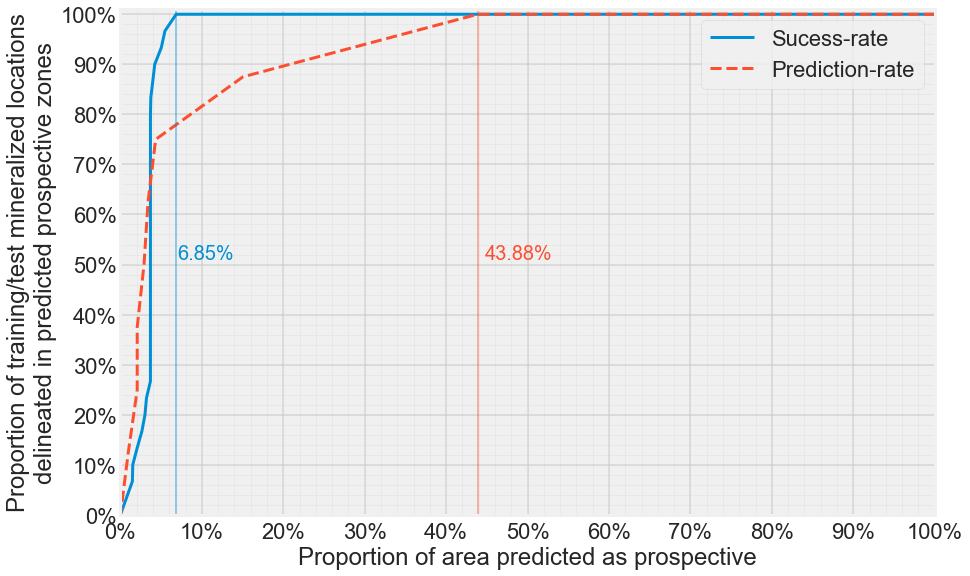

In [93]:
print_Area_Freq(capp_df_t,capp_df_v,0,'CAPP_Plot')